In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.autonotebook import tqdm, trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_38099/3230925853.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [4]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close

/tmp/ipykernel_38099/348662159.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close


In [5]:
# data_train = np.array( data[ : round(data.size*0.53) ] )
# data_val = np.array( data[ round(data.size*0.87) :  ] )

# scaler = StandardScaler()
# data_train = scaler.fit_transform(data_train.reshape(-1,1))
# data_val = scaler.transform(data_val.reshape(-1,1))

# print(f'Train shape: {data_train.size}\nVal shape: {data_val.size}')

train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()
train_data1 = data[ : round(data.shape[0]*0.53) ].to_numpy()
train_data2 = data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ].to_numpy()
val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

scaler = StandardScaler().fit(train_data.reshape(-1,1))
train_data1 = scaler.transform(train_data1.reshape(-1,1))
train_data2 = scaler.transform(train_data2.reshape(-1,1))
val_data = scaler.transform(val_data.reshape(-1,1))

print(f'Train shape: {train_data.size}\nVal shape: {val_data.size}')

Train shape: 6340
Val shape: 1585


In [6]:
def to_sequences(seq_size, obs, dec_seq_size):
    enc_in = []
    dec_in = []
    y = []
    for i in range(len(obs) - seq_size):
        enc_part = obs[i:(i + seq_size)]
        #dec_part = obs[ [i+seq_size-2, i+seq_size-1 ] ]
        dec_part = [obs[i+seq_size-j] for j in range(1, dec_seq_size+1) ]
        y_part = obs[i + seq_size]
        
        enc_in.append(enc_part)
        dec_in.append(dec_part)
        y.append(y_part)
        
    enc_in = torch.tensor(enc_in, dtype=torch.float32).view(-1, seq_size, 1)
    dec_in = torch.tensor(dec_in, dtype=torch.float32).view(-1, dec_seq_size, 1)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return enc_in, dec_in, y

In [168]:
SEQUENCE_SIZE = 32
dec_seq_size = 1

x_enc_train1, x_dec_train1, y_train1 = to_sequences(SEQUENCE_SIZE, train_data1, dec_seq_size)
x_enc_train2, x_dec_train2, y_train2 = to_sequences(SEQUENCE_SIZE, train_data2, dec_seq_size)
x_enc_val, x_dec_val, y_val = to_sequences(SEQUENCE_SIZE, val_data, dec_seq_size)


x_enc_train= torch.Tensor( np.concatenate([x_enc_train1, x_enc_train2]) )
x_dec_train= torch.Tensor( np.concatenate([x_dec_train1, x_dec_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )



train_dataset = TensorDataset(x_enc_train, x_dec_train, y_train)
val_dataset  = TensorDataset(x_enc_val, x_dec_val, y_val)                           

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

for x_enc_train, x_dec_train, y_ in train_loader:
    print(x_enc_train.shape)
    print(x_dec_train.shape)
    print(y_.shape)
    break

torch.Size([150, 32, 1])
torch.Size([150, 1, 1])
torch.Size([150, 1])


In [169]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=1, d_model=1024, nhead=16, num_layers=4, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder1 = nn.Linear(input_dim, d_model)
        self.ebedder2 = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        decoder_layers = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        enc = self.ebedder1(x[0])
        enc = self.pos_encoder(enc)
        enc = self.transformer_encoder(enc)
        dec = self.ebedder2( x[1] )
        out = self.transformer_decoder(dec, enc)[:,-1]
        out = self.head(out)
        return out

In [99]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/TRANS(ENC+DEC)(U)1D|||W=0.4713, VL=0.6563'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [170]:
model = TransformerModel( input_dim=1, d_model=512, nhead=8, num_layers=1, dropout=0.0).to(device)

In [171]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model( (x_enc, x_dec) )
        loss = criterion(outputs.view(-1, 1), y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,) , outputs.cpu().detach().reshape(-1,) )
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_enc, x_dec, y_batch = batch
            x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
            outputs = model( (x_enc, x_dec) )
            loss = criterion(outputs.view(-1, 1), y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,) )
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.00012:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для CUSTOM_TRANS val_loss = {val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 25:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.8f} Validation Loss: {val_loss:.8f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.44885353 Validation Loss: 0.00639313


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.01395293 Validation Loss: 0.00259080


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.00922720 Validation Loss: 0.00241925


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.00768454 Validation Loss: 0.00579033


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.00706914 Validation Loss: 0.00209741


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.00553928 Validation Loss: 0.00281884


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.00519418 Validation Loss: 0.00056883


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.00447435 Validation Loss: 0.00147922


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.00434255 Validation Loss: 0.00048431


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.00397230 Validation Loss: 0.00072364


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.00339321 Validation Loss: 0.00075616


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.00326461 Validation Loss: 0.00077382


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.5000e-04.
Epoch 13 / 50,Train Loss: 0.00327993 Validation Loss: 0.00100028


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.00276252 Validation Loss: 0.00064053


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.00258814 Validation Loss: 0.00059425


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.00259573 Validation Loss: 0.00078674


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.00255803 Validation Loss: 0.00046692


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.00225615 Validation Loss: 0.00039870


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.00232011 Validation Loss: 0.00050669


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.00224902 Validation Loss: 0.00047706


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.00225756 Validation Loss: 0.00047872


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 7.5000e-05.
Epoch 22 / 50,Train Loss: 0.00221499 Validation Loss: 0.00174671


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.00212253 Validation Loss: 0.00060748


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.00199337 Validation Loss: 0.00051419


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.00194826 Validation Loss: 0.00055338


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 3.7500e-05.
Epoch 26 / 50,Train Loss: 0.00197137 Validation Loss: 0.00060474


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.00194797 Validation Loss: 0.00072189


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.00194579 Validation Loss: 0.00060456


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.00193039 Validation Loss: 0.00042196


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.8750e-05.
Epoch 30 / 50,Train Loss: 0.00185170 Validation Loss: 0.00044754


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.00189346 Validation Loss: 0.00043651


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.00183436 Validation Loss: 0.00043047


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.00178597 Validation Loss: 0.00042390


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 9.3750e-06.
Epoch 34 / 50,Train Loss: 0.00180624 Validation Loss: 0.00045601


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.00175224 Validation Loss: 0.00042654


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.00177920 Validation Loss: 0.00044249


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.00179726 Validation Loss: 0.00046091


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 4.6875e-06.
Epoch 38 / 50,Train Loss: 0.00171230 Validation Loss: 0.00042615


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.00172181 Validation Loss: 0.00045894


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.00181582 Validation Loss: 0.00046203


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.00174865 Validation Loss: 0.00043628


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.3437e-06.
Epoch 42 / 50,Train Loss: 0.00178472 Validation Loss: 0.00043145


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 0m 52s


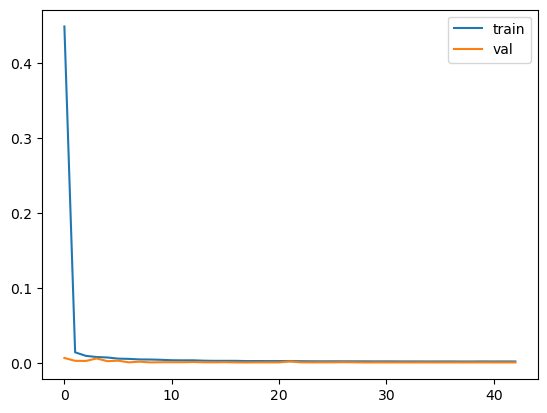

In [172]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['train','val'])

In [173]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [174]:
winrate(y_val.reshape(-1,), predictions1)

0.48260309278350516

In [175]:
y_val = scaler.inverse_transform(y_val)

In [176]:
predictions1 = scaler.inverse_transform(predictions1.reshape(-1,1))

In [177]:
criterion(torch.Tensor(y_val), torch.Tensor(predictions1))

tensor(2.4289)

In [178]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [179]:
winrate(y_train.reshape(-1,), predictions2.reshape(-1,))

0.47027972027972026

In [180]:
y_train = scaler.inverse_transform(y_train)

In [181]:
predictions2 = scaler.inverse_transform(predictions2.reshape(-1,1))

In [182]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(7.5143)

In [117]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,8,1,0.0]TRANS(ENC+DEC) (U) 1D|W=0.4761, TL=5.5226 VL=2.1319' )